## PHAS0102 Assignment 2 - Sparse Linear Algebra and GPU Acceleration

### Student Number: 19008330

Grade: 19/20 (95%)




In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, linalg, csc_matrix
from timeit import timeit
import numba
from numba import cuda, float32

### Part 1 - Solving a Wave equation using Sparse Matrices

1.1 Writing a Sparse Matrix Function. 


In [30]:
# Au = f
# f is a known vector
# A is a known matrix to be constructed
# u is to be determined using the linear equation


def sparse_wave_matrix(N):


  rows = []
  cols = []
  data = []

  '''
  Forming the known vector with boundary
  conditions in the following for loop. h represents
  the discrete steps for each iterative loop
  '''
  f = np.zeros(N+1)

  h = 1/N

  #The Wave-vector Constant
  k = (29/2)*np.pi

  '''
  This is the discretization for the points
  along the boundary
  '''
  for i in range(0,N+1):
    if i == N:
      f[i] = 1
      rows += [i]
      cols += [i]
      data += [1]
    elif i == 0:
      f[i] = 0
      rows += [i]
      cols += [i]
      data += [1]

  '''
  This is the stage where the main discretization
  occurs for the inner most points
  '''
  for i in range(1,N):
    rows += [i,i,i]
    cols += [i,i+1,i-1]
    data += [2-(h*k)**2, -1,-1]
  
  '''
  Appending all of these values to ensure the data 
  points are stored and can be retrieved
  '''

  rows = np.array(rows, dtype = np.float64)
  cols = np.array(cols, dtype = np.float64)
  data = np.array(data, dtype = np.float64)

  A_n = coo_matrix((data,(rows,cols)),(N+1,N+1))
  A = csc_matrix(A_n)
  return A,f



1.2 Determining the best value of $N$ based on plots. 

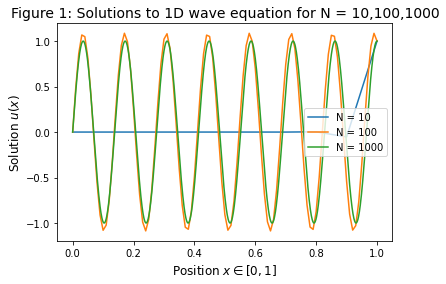

In [26]:
def soln(N):
  A, f = sparse_wave_matrix(N)
  solution = linalg.spsolve(A,f)
  return solution

data_range = np.array([10,100,1000])
for n in data_range:
  x = np.linspace(0,1,n+1)
  plt.plot(x, soln(n))
  plt.xlabel("Position $x \in [0,1]$", size = "12")
  plt.ylabel("Solution $u(x)$", size = "12")
  plt.legend(["N = 10", "N = 100", "N = 1000"])
  plt.title("Figure 1: Solutions to 1D wave equation for N = 10,100,1000", size = "14")

1.3 Comments on plots

Substantial differences are seen from $N = 10$ to $N = 100$ as the former value of N does not have enough discrete steps for an adequate approximate solution and $N = 1000$ is a significantly smoother plot than $N = 100$, which in its own right provides a better approximation than $N=10$. 

$N = 1000$ produces the closest numerical solution to the analytical solution. Analagous to fundamental calculus, smaller discrete step sizes $h = \frac{1}{N}$ correspond to the function being closer to the actual solution, thus higher values of $N$ lead to smaller discrete step sizes yielding a better solution.


1.4 The exact solution is $u_{\mathrm{exact}}(x) = \sin(kx)$. The error is found via in the following computation

$$ \mathrm{max}_i|u_i - u_{\mathrm{exact}}(x_i)|$$


Compute the errors and plot on log scales

**Notes: I took the formula for maximum error and adjusted to look for the mean error simultaneously. I had some concerns about the shape of the graph, later explained so I decided to examine the effects of both mean and maximum to see if the same pattern was observed, and indeed the same pattern was observed**

In [27]:
def error(N,error_type):
    N = int(N)    
    exact = []
    k = (29/2)*np.pi
    for i in np.linspace(0,1,N+1):
        exact.append(np.sin(k*i))
    solution = soln(N)

    if error_type == "max_absolute":
      return max(abs(solution - exact))
    if error_type == "mean_absolute":
      return np.mean(abs(solution - exact))

  
# I chose N = 1e5 to observe if the function works
# Furthermore, this is a value of N I would expect low error.
print("The maximum error yields:", error(100000, "max_absolute"))
print("The mean error yields:",error(100000, "mean_absolute"))


The maximum error yields: 3.701941853825885e-07
The mean error yields: 1.2196730746899918e-07


Text(0.5, 1.0, 'Figure 2a - Plot of $\\log_{10}(\\mathrm{Error})$ against $\\log_{10}(N)$')

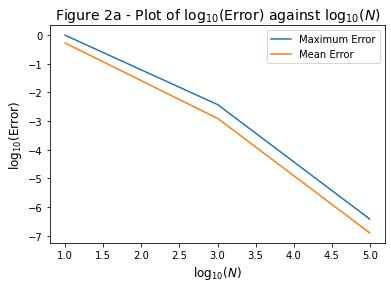

In [28]:
error_mean = []
error_max = []

x = N_range1 = range(int(1e1),int(1e5),int(1e3))

for i in N_range1:
    error_max.append(error(i, "max_absolute"))
    error_mean.append(error(i, "mean_absolute"))


y1 = error_max
y2 = error_mean
plt.plot(np.log10(x),np.log10(y1))
plt.plot(np.log10(x),np.log10(y2))
plt.xlabel("$\log_{10}(N)$", size = "12")
plt.ylabel("$\log_{10}(\mathrm{Error})$", size = "12")
plt.legend(["Maximum Error", "Mean Error"])
plt.title("Figure 2a - Plot of $\log_{10}(\mathrm{Error})$ against $\log_{10}(N)$", size = "14")

# Additional Comments

My prior concerns about possible anomalous behaviour of the maximum error have been negated. I shall primarily talk about maximum error as requested in the question from here on out. 

One can see the same graph is obtained on Figure 2a when plotting $\log_{10}(\mathrm{Error})$ against $\log_{10}(N)$. An almost perfectly linear graph demonstrates the maximum and mean error exponentially decrease with respect to the step size $N$ for the wave solution. The exponential decrease is greater from $N = 10^{3}$ to $N = 10^{5}$ than from $N = 10^{1}$ to $N = 10^{3}$.

One can see that the relative maximum error is between $10^{-6}$ and $10^{-7}$ when taking $N = 1.0 \times 10^{5}$ steps. I shall extend my range in the next cell to observe whether a maximum error of $10^{-8}$ can be achieved when moving to a step size  $N = 1.0 \times 10^{6}$. 


Text(0.5, 1.0, 'Figure 2b - Plot of $\\log_{10}(\\mathrm{Error})$ against \\log_{10}(N)$')

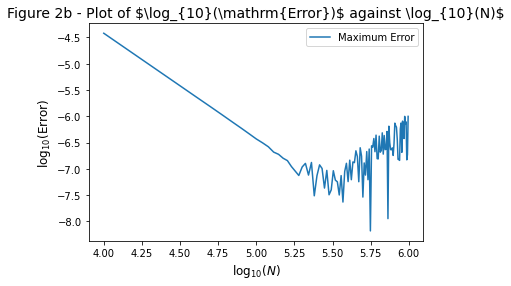

In [29]:
error_max = []
x = N_range2 = range(int(1e4),int(1e6),int(1e4))
for i in N_range2:
    error_max.append(error(i, "max_absolute"))

y1 = error_max
plt.plot(np.log10(x),np.log10(y1))
plt.xlabel("$\log_{10}(N)$", size = "12")
plt.ylabel("$\log_{10}(\mathrm{Error})$", size = "12")
plt.legend(["Maximum Error"])
plt.title("Figure 2b - Plot of $\log_{10}(\mathrm{Error})$ against \log_{10}(N)$", size = "14")



1.5 Time taken to compute $N$ in the ranges above.

In [7]:
# Modifying my function "func_time" from Assignment 1
# to compute the solution of N for any range of values

def func_time(operator,runs,range):
    def time_run(operator,N,runs):
        assign = {'soln' : soln, 'N' : N}
        return timeit(lambda: operator(N), number = runs, globals = assign)
        
    output = []
    for n in range:
      if runs == 0:
        break
      if runs == 1:
        output.append(time_run(operator,n,runs))
      if runs >1 :
        output.append(time_run(operator,n,runs)/runs)
   
    return np.array(output)


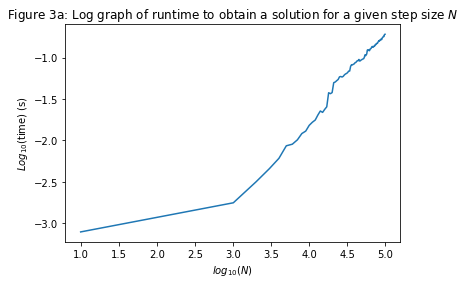

In [8]:
N1 = range(int(1e1),int(1e5),int(1e3))
t1 = func_time(soln,10,N1)

plt.plot(np.log10(N1), np.log10(t1))
plt.xlabel("$log_{10}(N)$")
plt.ylabel("$Log_{10}(\mathrm{time})$ (s)")
plt.title("Figure 3a: Log graph of runtime to obtain a solution for a given step size $N$")
plt.show()

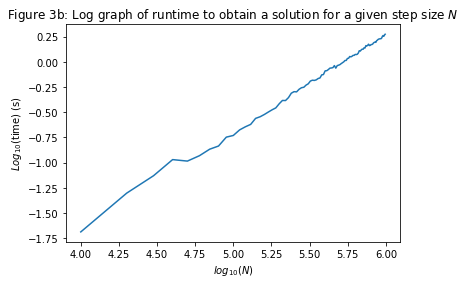

In [9]:
N2 = range(int(1e4),int(1e6),int(1e4))
t2 = func_time(soln,1,N2) 
plt.plot(np.log10(N2), np.log10(t2))
plt.xlabel("$log_{10}(N)$")
plt.ylabel("$Log_{10}(\mathrm{time})$ (s)")
plt.title("Figure 3b: Log graph of runtime to obtain a solution for a given step size $N$")
plt.show()

Figure 3a gives the runtime to compute the range seen in Figure 2a and Figure 3b gives the runtime for the range seen in Figure 2b.

1.6 Determining a value of $N$ which yields an error sensitivity of $10^{-8}$ or less and predicting time to compute this value of $N$.

*Further Observations: From Figure 2b, one can observe the instability in the maximum error of the solution obtained earlier for values of $N >10^{5}$; this inherent instability is expected when computing a finite difference reccursion for very large values of $N$, a small caveat with this approximation method*.

**Answer:** From reading off Figures 2a and 3a, my prediction for the value of $N$ required ranges approximately from $N \in \big[10^{5.3}, 10^{5.8} \hspace{0.1cm} \big]$ for the first instance of a maximum error reaching $10^{-8}$. The time to compute $N$ for this maximum error should take between 0.39s and 1.75s, obtained by reading off Figures 2b and 3b. This corresponds to a range of $N = 199526$ to $N = 630957$, which is a large range taken into account due to the graph moving in steps of 1000.

1.7 Compute the approximate solution with your value of $N$. Measure the time taken and the error, and briefly (1-2 sentences) comment on how these compare to your predictions.

In [10]:
N_estimate = np.arange(230000,230100,1)
for i in N_estimate:
  err = error(i,"max_absolute")
  if err < 1e-8:
    print("The minimum N to retrieve maximum error is less than 1e-8 = ",i)
    break

The minimum N to retrieve maximum error is less than 1e-8 =  230072


In [18]:
e = 230072
print(np.log10(e))
# The 3rd argument of func_time requires a list format as its typically
# built for ranges and not single value, hence the square brackets
print("Time taken to compute N which gives sub 1e-8 maximum error = ",func_time(soln,10,[e])[0])

5.361863767797629
Time taken to compute N which gives sub 1e-8 maximum error =  0.5051105413999949


The earliest value of $N$ I was able to detect to reach a sensitivity $\leq 10^{-8}$ was at $N_{\mathrm{min}} = 230072$ or an approximate value of $\log(N) = 5.3619$, closer to the lower bound estimate thankfully.

This fits well within the expected range, the instability of the graph in Figure 2b gave rise to a large possible range for $N_{\mathrm{min}}$. The time taken to compute the error using my function is $t = 0.505$s which fits perfectly within the range I provided in my prediction. 


### Part 2 - Solving the heat equation with GPU acceleration

2.1 Implement this iterative scheme in Python. You should implement this as a function that takes $N$ as an input.


Text(0.5, 1.0, 'Figure 4a: The temperature at each point $x_i$ at time t')

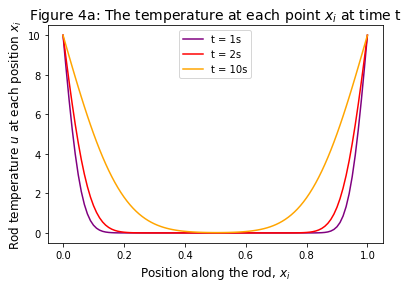

In [22]:
def heat(N,t):
  # interval spacing depending on input N
  #h = 1/N
  '''
  This constant k will become vital to explain PDE stability
  '''
  k = N/1000
  # Setting up the grid with endpoint boundary conditions
  u = np.empty(N+1, dtype = "float64")

  '''
  The initial conditions along the boundaries
  of the rod as well as in the middle.
  '''
  u[0] = u[N] = 10
  u[1:N-1] = 0

  for j in range(N*t):
    for i in range(1,N):
      u[i] = u[i] + k*(u[i-1] - 2*u[i] + u[i+1])
  return u



N = 100
t1 = 1
t2 = 2
t3 = 10
x = np.linspace(0,1,N+1)
y1 = heat(N,t1)
y2 = heat(N,t2)
y3 = heat(N,t3)

plt.plot(x,y1, color = "purple")
plt.plot(x,y2, color = "red")
plt.plot(x,y3, color = "orange")
plt.legend(["t = 1s", "t = 2s", "t = 10s"])
plt.ylabel("Rod temperature $u$ at each position $x_i$", size = "12")
plt.xlabel("Position along the rod, $x_i$", size = "12")
plt.title("Figure 4a: The temperature at each point $x_i$ at time t", size = "14")



2.2 Using a sensible value of $N$, plot the temperature of the rod at $t = 1$, $t = 2$, $t = 10$. Comment on how you picked a value for $N$.

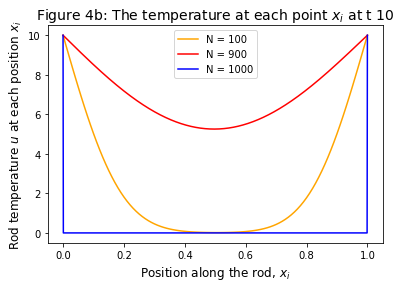

In [13]:
N1 = 100
N2 = 900
N3 = 1000
x1 = np.linspace(0,1,N1+1)
x2 = np.linspace(0,1,N2+1)
x3 = np.linspace(0,1,N3+1)
plt.plot(x1, heat(N1,10), color = "orange")
plt.plot(x2, heat(N2,10), color = "red")
plt.plot(x3, heat(N3,10), color = "blue")
plt.legend(["N = 100", "N = 900","N = 1000",])
plt.ylabel("Rod temperature $u$ at each position $x_i$", size = "12")
plt.xlabel("Position along the rod, $x_i$", size = "12")
plt.title("Figure 4b: The temperature at each point $x_i$ at t 10", size = "14")
plt.show()

I've chosen a value of $N = 100$ as it there are enough discrete steps to plot a good solution one would expect. The constant $k = \frac{1}{1000h}$ holds the key to the heat equation's stability; the closer this value approaches unity, the more unstable the solution becomes, akin to discretizing other PDE's like the wave equation. $N = 900$ yields a solution which is very unrealistic after 10 time intervals and $N=1000$ mirrors the boundary conditions. This means that too large a value $N$ will lead to a poor numerical solution. Hence why I stuck with $N = 100$, to maintain a relatively sensible and stable solutions; furthermore, we obtain a very fast runtime which is preferable.

2.3 Use ``numba.cuda`` to parallelise your implementation on a GPU. You should think carefully about when data needs to be copied, and be careful not to copy data to/from the GPU when not needed.

Text(0.5, 1.0, 'Figure 4c: The temperature at each point $x_i$ at time t, with GPU acceleration')

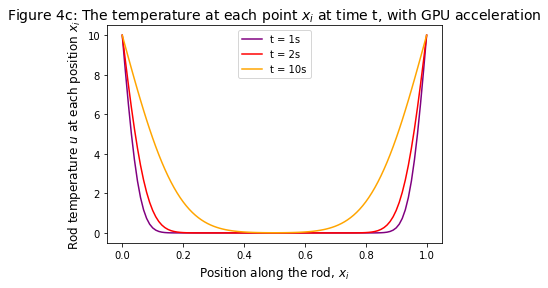

In [31]:
def cuda_heat(N,t):
  '''
  I've opted for a nested function to deal with the
  frustrating formatting of numba.cuda
  '''
  @cuda.jit
  def cuda_heat_solution(u,N):
    '''
    using numpy arrays for the solution. before setting
    the interior points in cuda will lead to errors. Hence, 
    the need to cuda.grid to form a 1D solution
    '''
    i = cuda.grid(1) # Produces a 1-D array
    if 0 < i < N:
      u[i] = u[i] + k*(u[i-1] - 2*u[i] + u[i+1])
      
      '''
      This runs the iterative loop before implementation for 
      all interior points in the solution
      '''       
      
  h = 1/N
  k = N/1000
  griddim = (128,)
  blockdim = (256,)
  
  u = np.empty(N+1, dtype = "float32")
  u[0] = u[N] = 10
  u[1:N-1] = 0
  u_cuda = cuda.to_device(u)
  
  t_j = numba.prange(1,N*t)
  t_cuda = cuda.to_device(t_j)
  for j in t_cuda:
    cuda_heat_solution[griddim,blockdim](u_cuda,N)
      
  cuda.synchronize()

  '''
  The solution returns as a cuda array, values inside remain
  unreadable unless the array is copied to host again as outlined 
  below.
  '''

  host_array = np.empty(shape = u_cuda.shape, dtype = "float32")
  solution = u_cuda.copy_to_host(host_array)
  return solution

N = 100
t1 = 1
t2 = 2
t3 = 10
x = np.linspace(0,1,N+1)
y1 = cuda_heat(N,t1)
y2 = cuda_heat(N,t2)
y3 = cuda_heat(N,t3)

plt.plot(x,y1, color = "purple")
plt.plot(x,y2, color = "red")
plt.plot(x,y3, color = "orange")
plt.legend(["t = 1s", "t = 2s", "t = 10s"])
plt.ylabel("Rod temperature $u$ at each position $x_i$", size = "12")
plt.xlabel("Position along the rod, $x_i$", size = "12")
plt.title("Figure 4c: The temperature at each point $x_i$ at time t, with GPU acceleration", size = "14")


2.4 Use your code to estimate the time at which the temperature of the midpoint of the rod first exceeds a temperature of 9.8. Briefly (2-3 sentences) describe how you estimated this time. You may choose to use a plot or diagram to aid your description, but it is not essential to include a plot.

In [15]:
N = 100
midpoint = int(N/2)
t = np.arange(0,600,10)
mid_temp = []
for i in t:
  mid_temp.append(cuda_heat(N,i)[midpoint])


Text(0.5, 1.0, 'Figure 5: Midpoint Temperature of the rod after time $t$')

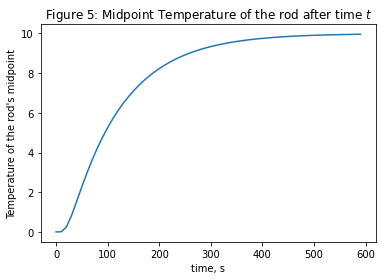

In [16]:
plt.plot(t, mid_temp)
plt.xlabel("time, s")
plt.ylabel("Temperature of the rod's midpoint")
plt.title("Figure 5: Midpoint Temperature of the rod after time $t$")

Figure 5 indicates the time the midpoint of the rod takes to reach 9.8s is between 400s and 600s. I will investigate from 400 to 430 to see if the change happens early in the estimates interval.

In [17]:
N = 100
midpoint = int(N/2)
t = np.arange(400,430,1)
mid_temp = []
for i in t:
  mid_temp = cuda_heat(N,i)[midpoint]
  print("Time = ", i, "Temperature = ", mid_temp)

Time =  400 Temperature =  9.753402
Time =  401 Temperature =  9.755792
Time =  402 Temperature =  9.758176
Time =  403 Temperature =  9.76056
Time =  404 Temperature =  9.762913
Time =  405 Temperature =  9.765202
Time =  406 Temperature =  9.76749
Time =  407 Temperature =  9.769779
Time =  408 Temperature =  9.772062
Time =  409 Temperature =  9.774273
Time =  410 Temperature =  9.776466
Time =  411 Temperature =  9.77866
Time =  412 Temperature =  9.780853
Time =  413 Temperature =  9.782982
Time =  414 Temperature =  9.78508
Time =  415 Temperature =  9.787178
Time =  416 Temperature =  9.789276
Time =  417 Temperature =  9.7913685
Time =  418 Temperature =  9.793389
Time =  419 Temperature =  9.795392
Time =  420 Temperature =  9.797395
Time =  421 Temperature =  9.799397
Time =  422 Temperature =  9.801374
Time =  423 Temperature =  9.803282
Time =  424 Temperature =  9.805189
Time =  425 Temperature =  9.8070965
Time =  426 Temperature =  9.809004
Time =  427 Temperature =  9.8

From the printed values just above, it is clear the earliest time the midpoint first exceeds $u =9.8$ was at $t = 422$. Therefore the the time taken for $u = 9.8$ lays between $t = 421$ and $t = 422$. 